In [ ]:
# !pip install pandas
# !pip install scikit-learn
# !pip install xgboost
# !pip install lightgbm
# !pip install optuna
# !pip install catboost
# !pip install numpy
# !pip install seaborn



Defaulting to user installation because normal site-packages is not writeable


In [40]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
import optuna
import seaborn as sns
import matplotlib.pyplot as plt

# Load Train and Test

In [9]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [10]:
train.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [11]:
train.shape

(165034, 14)

# Data Investigation

In [36]:
train.isnull().sum()

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [37]:
rows, columns = train.shape
print(f'Rows: {rows}')
print(f'Columns: {columns}')

Rows: 165034
Columns: 16


In [36]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 16 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CreditScore      165034 non-null  int64  
 1   Geography        165034 non-null  object 
 2   Gender           165034 non-null  object 
 3   Age              165034 non-null  float64
 4   Tenure           165034 non-null  int64  
 5   Balance          165034 non-null  float64
 6   NumOfProducts    165034 non-null  int64  
 7   HasCrCard        165034 non-null  float64
 8   IsActiveMember   165034 non-null  float64
 9   EstimatedSalary  165034 non-null  float64
 10  Exited           165034 non-null  float64
 11  isMale           165034 non-null  int64  
 12  Germany          165034 non-null  int64  
 13  Spain            165034 non-null  int64  
 14  Geography_Freq   165034 non-null  float64
 15  Geography_Mean   165034 non-null  float64
dtypes: float64(8), int64(6), object(2)
mem

In [39]:
cats = train.select_dtypes('object')

for c in cats.columns:
    print(c, cats[c].unique())

Surname ['Okwudilichukwu' 'Okwudiliolisa' 'Hsueh' ... 'Aliyev' 'McMinn' 'Elkins']
Geography ['France' 'Spain' 'Germany']
Gender ['Male' 'Female']


In [40]:
train['Exited'].unique()

array([0, 1])

In [41]:
train[train['Exited'].isnull()]

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited


In [42]:
train['Exited'].value_counts()

Exited
0    130113
1     34921
Name: count, dtype: int64

In [43]:
print(f'No churn: {train['Exited'].value_counts()[0]} or {train['Exited'].value_counts()[0] / len(train) * 100:.2f}%')
print(f'Churn: {train['Exited'].value_counts()[1]} or {train['Exited'].value_counts()[1] / len(train) * 100:.2f}%')
print(f'Total: {len(train)}')

No churn: 130113 or 78.84%
Churn: 34921 or 21.16%
Total: 165034


In [35]:
train[train.duplicated(subset='CreditScore')==False]

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,isMale,Germany,Spain,Geography_Freq,Geography_Mean
20078,350,France,Female,51.0,1,0.00,1,1.0,1.0,125823.79,0.0,0,0,0,0.572194,0.165282
81694,358,Germany,Male,57.0,7,139675.07,2,1.0,0.0,45591.23,1.0,1,1,0,0.209211,0.378952
169,359,France,Female,44.0,6,128747.69,1,0.0,1.0,146955.71,0.0,0,0,0,0.572194,0.165282
14479,363,Spain,Male,28.0,6,0.00,2,0.0,0.0,100615.14,0.0,1,0,1,0.218595,0.172176
40827,365,Germany,Male,30.0,9,127760.07,2,0.0,1.0,81537.85,0.0,1,1,0,0.209211,0.378952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1578,846,Germany,Female,42.0,10,129118.50,1,1.0,0.0,119747.08,1.0,0,1,0,0.209211,0.378952
5128,847,Germany,Male,33.0,10,133200.21,2,1.0,1.0,49424.37,0.0,1,1,0,0.209211,0.378952
2003,848,Germany,Female,40.0,0,148495.64,2,1.0,0.0,158853.98,1.0,0,1,0,0.209211,0.378952
7217,849,France,Female,40.0,1,0.00,1,1.0,0.0,45424.45,1.0,0,0,0,0.572194,0.165282


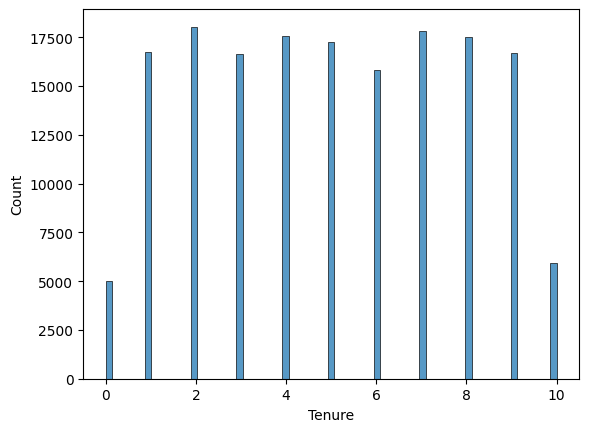

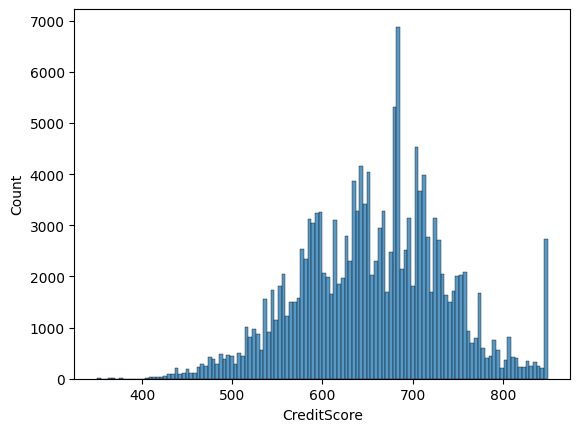

In [44]:
# Create histograms

# sns.histplot(train['Age'], kde=False)
# plt.show()

# sns.histplot(train['NumOfProducts'], kde=False)
# plt.show()

sns.histplot(train['Tenure'], kde=False)
plt.show()

sns.histplot(train['CreditScore'], kde=False)
plt.show()

# Label Encode Categorical Features

In [20]:
# getting an additional row in the data somehow below. Exited is NaN

In [21]:
# RMV = ['id', 'CustomerId', 'Surname', 'Exited']
# FEATURES = [c for c in train.columns if not c in RMV]
# combined = pd.concat([train,test], axis=0, ignore_index=True)
# CATS = []

# for c in FEATURES:
#     ftype = 'numerical'
#     if combined[c].dtype == 'object':
#         CATS.append(c)
#         ftype = 'categorical'
#     if combined[c].dtype == 'int64':
#         combined[c] = combined[c].astype('int32')
#     elif combined[c].dtype == 'float64':
#         combined[c] = combined[c].astype('float32')
        
# train = combined.iloc[:len(train)].copy()
# test = combined.iloc[len(train):].reset_index(drop=True).copy()
# train.head()

# Train Models

In [12]:
print(len(train))
print(len(test))

165034
110023


In [13]:
combined = pd.concat([train, test], axis=0, ignore_index=True).copy()
combined.drop(['id','CustomerId','Surname'], axis=1, inplace=True)

In [14]:
combined['isMale'] = combined['Gender'].map({'Male':1,'Female':0})
combined

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,isMale
0,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0.0,1
1,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0.0,1
2,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0.0,1
3,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0.0,1
4,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
275052,570,Spain,Male,29.0,7,116099.82,1,1.0,1.0,148087.62,NaN,1
275053,575,France,Female,36.0,4,178032.53,1,1.0,1.0,42181.68,NaN,0
275054,712,France,Male,31.0,2,0.00,2,1.0,0.0,16287.38,NaN,1
275055,709,France,Female,32.0,3,0.00,1,1.0,1.0,158816.58,NaN,0


In [15]:
combined['Geography'].value_counts()

Geography
France     157386
Spain       60126
Germany     57545
Name: count, dtype: int64

In [16]:
dummy_geo = pd.get_dummies(combined['Geography'], columns=['Geography'], drop_first=True, dtype='int')
dummy_geo

,Germany,Spain
0,0,0
1,0,0
2,0,0
3,0,0
4,0,1
...,...,...
275052,0,1
275053,0,0
275054,0,0
275055,0,0


In [17]:
combined = pd.concat([combined, dummy_geo], axis=1)
combined

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,isMale,Germany,Spain
0,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0.0,1,0,0
1,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0.0,1,0,0
2,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0.0,1,0,0
3,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0.0,1,0,0
4,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0.0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275052,570,Spain,Male,29.0,7,116099.82,1,1.0,1.0,148087.62,NaN,1,0,1
275053,575,France,Female,36.0,4,178032.53,1,1.0,1.0,42181.68,NaN,0,0,0
275054,712,France,Male,31.0,2,0.00,2,1.0,0.0,16287.38,NaN,1,0,0
275055,709,France,Female,32.0,3,0.00,1,1.0,1.0,158816.58,NaN,0,0,0


In [18]:
freq_geo = combined['Geography'].value_counts(normalize=True)
combined['Geography_Freq'] = combined['Geography'].map(freq_geo)
combined

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,isMale,Germany,Spain,Geography_Freq
0,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0.0,1,0,0,0.572194
1,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0.0,1,0,0,0.572194
2,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0.0,1,0,0,0.572194
3,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0.0,1,0,0,0.572194
4,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0.0,1,0,1,0.218595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275052,570,Spain,Male,29.0,7,116099.82,1,1.0,1.0,148087.62,NaN,1,0,1,0.218595
275053,575,France,Female,36.0,4,178032.53,1,1.0,1.0,42181.68,NaN,0,0,0,0.572194
275054,712,France,Male,31.0,2,0.00,2,1.0,0.0,16287.38,NaN,1,0,0,0.572194
275055,709,France,Female,32.0,3,0.00,1,1.0,1.0,158816.58,NaN,0,0,0,0.572194


In [19]:
mean_geo = combined.groupby('Geography')['Exited'].mean()
combined['Geography_Mean'] = combined['Geography'].map(mean_geo)
combined

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,isMale,Germany,Spain,Geography_Freq,Geography_Mean
0,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0.0,1,0,0,0.572194,0.165282
1,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0.0,1,0,0,0.572194,0.165282
2,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0.0,1,0,0,0.572194,0.165282
3,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0.0,1,0,0,0.572194,0.165282
4,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0.0,1,0,1,0.218595,0.172176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275052,570,Spain,Male,29.0,7,116099.82,1,1.0,1.0,148087.62,NaN,1,0,1,0.218595,0.172176
275053,575,France,Female,36.0,4,178032.53,1,1.0,1.0,42181.68,NaN,0,0,0,0.572194,0.165282
275054,712,France,Male,31.0,2,0.00,2,1.0,0.0,16287.38,NaN,1,0,0,0.572194,0.165282
275055,709,France,Female,32.0,3,0.00,1,1.0,1.0,158816.58,NaN,0,0,0,0.572194,0.165282


In [20]:
train = combined[:len(train)].copy()
test = combined[len(train):].reset_index(drop=True).copy()

In [21]:
X = train.drop('Exited', axis=1)
y = train[['Exited']]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
predictors = [
    'CreditScore',
    'Age', 
    'Tenure', 
    'Balance',
    'NumOfProducts', 
    'HasCrCard', 
    'IsActiveMember', 
    'EstimatedSalary',
    'isMale', 
    'Germany', 
    'Spain', 
    'Geography_Freq', 
    'Geography_Mean'
]

## CatBoost

In [25]:
model = CatBoostClassifier(learning_rate=1, depth=6, loss_function='Logloss')
fit_model = model.fit(X_train[predictors], y_train)

print(fit_model.get_params())

0:	learn: 0.3376721	total: 124ms	remaining: 2m 4s
1:	learn: 0.3256564	total: 188ms	remaining: 1m 33s
2:	learn: 0.3238948	total: 257ms	remaining: 1m 25s
3:	learn: 0.3223110	total: 329ms	remaining: 1m 22s
4:	learn: 0.3213668	total: 676ms	remaining: 2m 14s
5:	learn: 0.3208754	total: 774ms	remaining: 2m 8s
6:	learn: 0.3199341	total: 836ms	remaining: 1m 58s
7:	learn: 0.3197186	total: 1s	remaining: 2m 4s
8:	learn: 0.3194666	total: 1.09s	remaining: 1m 59s
9:	learn: 0.3190700	total: 1.14s	remaining: 1m 53s
10:	learn: 0.3186074	total: 1.25s	remaining: 1m 52s
11:	learn: 0.3183547	total: 1.35s	remaining: 1m 51s
12:	learn: 0.3180912	total: 1.43s	remaining: 1m 48s
13:	learn: 0.3176915	total: 1.54s	remaining: 1m 48s
14:	learn: 0.3171957	total: 1.63s	remaining: 1m 46s
15:	learn: 0.3169731	total: 1.73s	remaining: 1m 46s
16:	learn: 0.3166125	total: 1.81s	remaining: 1m 44s
17:	learn: 0.3163287	total: 1.88s	remaining: 1m 42s
18:	learn: 0.3159636	total: 1.95s	remaining: 1m 40s
19:	learn: 0.3156000	total: 

In [26]:
# Make predictions on the test set
y_pred_prob = fit_model.predict(X_val[predictors])
y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_prob]

# Evaluate the model
score = roc_auc_score(y_val, y_pred)
print(f"Score: {score:.2f}")

# Print a detailed classification report
print("Classification Report:")
print(classification_report(y_val, y_pred))

Score: 0.74
Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.92      0.90     26052
         1.0       0.65      0.55      0.59      6955

    accuracy                           0.84     33007
   macro avg       0.76      0.74      0.75     33007
weighted avg       0.83      0.84      0.84     33007



## XGBoost

In [172]:
train_dmatrix = xgb.DMatrix(data=X_train[predictors], label=y_train)
val_dmatrix = xgb.DMatrix(data=X_val[predictors], label=y_val)

In [173]:
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 3,
    'learning_rate': 0.1,
    'seed': 42
}

In [174]:
num_round = 100
bst = xgb.train(params, train_dmatrix, num_round)

In [ ]:
# Make predictions on the test set
y_pred_prob = bst.predict(val_dmatrix)
y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_prob]

# Evaluate the model
score = roc_auc_score(y_val, y_pred)
print(f"Score: {score:.2f}")

# Print a detailed classification report
print("Classification Report:")
print(classification_report(y_val, y_pred))

Score: 0.75
Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.95      0.92     26052
         1.0       0.76      0.54      0.63      6955

    accuracy                           0.87     33007
   macro avg       0.82      0.75      0.77     33007
weighted avg       0.86      0.87      0.86     33007



## LightGBM

In [193]:
d_train = lgb.Dataset(X_train[predictors], label=y_train)

In [199]:
params = {
    "objective": "binary",          # Binary classification
    "metric": "binary_logloss",     # Loss function for binary classification
    "boosting_type": "gbdt",        # Gradient Boosting Decision Tree
    "num_leaves": 31,               # Maximum number of leaves in a tree
    "learning_rate": 0.07,          # Step size for each iteration
    "feature_fraction": 0.8         # Percentage of features to use per iteration
}

model = lgb.train(params, d_train, num_boost_round=100)

[LightGBM] [Info] Number of positive: 27966, number of negative: 104061
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 868
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211820 -> initscore=-1.313988
[LightGBM] [Info] Start training from score -1.313988


In [200]:
y_pred = model.predict(X_val[predictors])

# Convert probabilities to binary predictions
y_pred = (y_pred > 0.5).astype(int)

# Evaluate the model
score = roc_auc_score(y_val, y_pred)
print(f"Score: {score:.2f}")

# Print a detailed classification report
print("Classification Report:")
print(classification_report(y_val, y_pred))

Score: 0.76
Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.95      0.92     26052
         1.0       0.75      0.56      0.64      6955

    accuracy                           0.87     33007
   macro avg       0.82      0.76      0.78     33007
weighted avg       0.86      0.87      0.86     33007



In [215]:
def objective(trial):
    # Define the hyperparameters to tune
    params = {
        "objective": "binary",
        "metric": "binary_logloss",
        "boosting_type": "gbdt",
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.10),
        "num_leaves": trial.suggest_int("num_leaves", 20, 300),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-8, 10.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-8, 10.0),
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
    }
    
    # Train the LightGBM model
    dtrain = lgb.Dataset(X_train[predictors], label=y_train)
    dval = lgb.Dataset(X_val[predictors], label=y_val, reference=dtrain)
    model = lgb.train(params, dtrain, valid_sets=[dval])

    # Make predictions and calculate accuracy
    y_pred = model.predict(X_val[predictors])
    y_pred = (y_pred > 0.5).astype(int)

    # Evaluate the model
    score = roc_auc_score(y_val, y_pred)
    print(f"Score: {score:.2f}")

In [216]:
study = optuna.create_study(direction="maximize")  # Maximize accuracy
study.optimize(objective, n_trials=5)  # Try 5 combinations

print("Best hyperparameters:", study.best_params)
print("Best accuracy:", study.best_value)

[I 2025-01-17 01:31:46,395] A new study created in memory with name: no-name-5a9a53d0-dac3-40be-b1fd-655179a778aa
/tmp/ipykernel_900/353718117.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.10),
/tmp/ipykernel_900/353718117.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
/tmp/ipykernel_900/353718117.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0

[LightGBM] [Info] Number of positive: 27966, number of negative: 104061
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001977 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 868
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211820 -> initscore=-1.313988
[LightGBM] [Info] Start training from score -1.313988
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[W 2025-01-17 01:31:56,813] Trial 0 failed with parameters: {'learning_rate': 0.03179598652071104, 'num_leaves': 270, 'max_depth': 5, 'min_child_samples': 58, 'subsample': 0.8092255998148195, 'colsample_bytree': 0.6475982263183981, 'reg_alpha': 0.08123278250373347, 'reg_lambda': 0.001297861603807933, 'n_estimators': 493} because of the following error: The value None could not be cast to float..
[W 2025-01-17 01:31:56,814] Trial 0 failed with value None.


Score: 0.76
[LightGBM] [Info] Number of positive: 27966, number of negative: 104061


/tmp/ipykernel_900/353718117.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.10),
/tmp/ipykernel_900/353718117.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
/tmp/ipykernel_900/353718117.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
/tmp/ipykernel_900/353718117.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014694 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 868
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211820 -> initscore=-1.313988
[LightGBM] [Info] Start training from score -1.313988
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[W 2025-01-17 01:32:15,116] Trial 1 failed with parameters: {'learning_rate': 0.03056754066354571, 'num_leaves': 250, 'max_depth': 11, 'min_child_samples': 97, 'subsample': 0.9481425742454206, 'colsample_bytree': 0.5292100601372745, 'reg_alpha': 1.637434085240971e-08, 'reg_lambda': 3.565486295234875e-08, 'n_estimators': 282} because of the following error: The value None could not be cast to float..
[W 2025-01-17 01:32:15,118] Trial 1 failed with value None.


Score: 0.75


/tmp/ipykernel_900/353718117.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.10),
/tmp/ipykernel_900/353718117.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
/tmp/ipykernel_900/353718117.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
/tmp/ipykernel_900/353718117.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

[LightGBM] [Info] Number of positive: 27966, number of negative: 104061
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 868
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211820 -> initscore=-1.313988
[LightGBM] [Info] Start training from score -1.313988
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[W 2025-01-17 01:32:26,162] Trial 2 failed with parameters: {'learning_rate': 0.024791265099924912, 'num_leaves': 115, 'max_depth': 4, 'min_child_samples': 97, 'subsample': 0.8932761933018945, 'colsample_bytree': 0.7389575491644385, 'reg_alpha': 0.05246735543684642, 'reg_lambda': 2.6231814829254056e-08, 'n_estimators': 447} because of the following error: The value None could not be cast to float..
[W 2025-01-17 01:32:26,163] Trial 2 failed with value None.


Score: 0.76
[LightGBM] [Info] Number of positive: 27966, number of negative: 104061


/tmp/ipykernel_900/353718117.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.10),
/tmp/ipykernel_900/353718117.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
/tmp/ipykernel_900/353718117.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
/tmp/ipykernel_900/353718117.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 868
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211820 -> initscore=-1.313988
[LightGBM] [Info] Start training from score -1.313988
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[W 2025-01-17 01:32:31,185] Trial 3 failed with parameters: {'learning_rate': 0.010505107836577562, 'num_leaves': 82, 'max_depth': 5, 'min_child_samples': 19, 'subsample': 0.7105874094364273, 'colsample_bytree': 0.7200220321511437, 'reg_alpha': 1.0750999315520894e-05, 'reg_lambda': 0.00045469667418765366, 'n_estimators': 234} because of the following error: The value None could not be cast to float..
[W 2025-01-17 01:32:31,186] Trial 3 failed with value None.


Score: 0.73


/tmp/ipykernel_900/353718117.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.10),
/tmp/ipykernel_900/353718117.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
/tmp/ipykernel_900/353718117.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
/tmp/ipykernel_900/353718117.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

[LightGBM] [Info] Number of positive: 27966, number of negative: 104061
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002257 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 868
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211820 -> initscore=-1.313988
[LightGBM] [Info] Start training from score -1.313988
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[W 2025-01-17 01:32:39,591] Trial 4 failed with parameters: {'learning_rate': 0.010160086049255355, 'num_leaves': 54, 'max_depth': 11, 'min_child_samples': 86, 'subsample': 0.829698020924384, 'colsample_bytree': 0.5849770899608961, 'reg_alpha': 8.308948168297654, 'reg_lambda': 5.2883724187913806e-08, 'n_estimators': 388} because of the following error: The value None could not be cast to float..
[W 2025-01-17 01:32:39,594] Trial 4 failed with value None.


Score: 0.75


ValueError: No trials are completed yet.

In [217]:
best_params = study.best_params

best_model = lgb.LGBMClassifier(**best_params)

# Evaluate on the validation set
test_preds = best_model.predict(test[predictors])
test_preds = [1 if prob > 0.5 else 0 for prob in test_preds]

ValueError: No trials are completed yet.

In [ ]:
submission['Exited'] = test_preds
submission.to_csv('data/submission.csv', index=False)
submission

# Create Submission CSV

In [213]:
submission = pd.read_csv('data/sample_submission.csv')
submission.head()

,id,Exited
0,165034,0.5
1,165035,0.5
2,165036,0.5
3,165037,0.5
4,165038,0.5


## Benchmark

### Random Guess

In [27]:
# dummy model - approx 1 in 5 customers churn (20% churn rate)
random_preds = submission.sample(frac=0.20, random_state=42).index
random_preds

Index([16412, 81431, 80555, 90124, 37688, 56720, 57437, 25027, 40756, 31166,
       ...
       22481, 12095, 86880, 46552, 97149, 74384, 41331, 10459, 53808, 33429],
      dtype='int64', length=22005)

In [28]:
for i in submission.index:
    if i in random_preds:
        submission.loc[i, 'Exited'] = 1
    else:
        submission.loc[i, 'Exited'] = 0

submission.head()

,id,Exited
0,165034,0.0
1,165035,0.0
2,165036,0.0
3,165037,1.0
4,165038,0.0


### Guess No One Churns

In [102]:
submission['Exited'] = 0
submission.to_csv('data/submission.csv', index=False) 
submission

,id,Exited
0,165034,0
1,165035,0
2,165036,0
3,165037,0
4,165038,0
...,...,...
110018,275052,0
110019,275053,0
110020,275054,0
110021,275055,0


## XGBoost

In [178]:
test_dmatrix = xgb.DMatrix(data=test[predictors])

In [179]:
# Make predictions on the test set
test_preds = bst.predict(test_dmatrix)
test_preds = [1 if prob > 0.5 else 0 for prob in test_preds]

In [182]:
submission['Exited'] = test_preds
submission.to_csv('data/submission.csv', index=False)
submission

,id,Exited
0,165034,0
1,165035,1
2,165036,0
3,165037,0
4,165038,0
...,...,...
110018,275052,0
110019,275053,0
110020,275054,0
110021,275055,0


Goal:
- Predict bank customer churn

To Do:
- Train/Test split
- Review feature distributions
- Preprocessing
- Encode categorical variables
- Scale variables?
- Drop features that aren't predictive
- Label Target variable (Exited)
- AUC ROC is the evaluation metric
- Estabilish baseline model (avg?)
- Evaluation framework
- Using best model make predictions
- Submit predictions